In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torchvision
import PIL.Image
import numpy as np
import tqdm

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch.nn import init
from matplotlib import pyplot as plt

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
import zipfile

if not os.path.isdir('targetdir/'):
  with zipfile.ZipFile("drive/MyDrive/RealPhotos.zip","r") as zip_ref:
      zip_ref.extractall("targetdir")


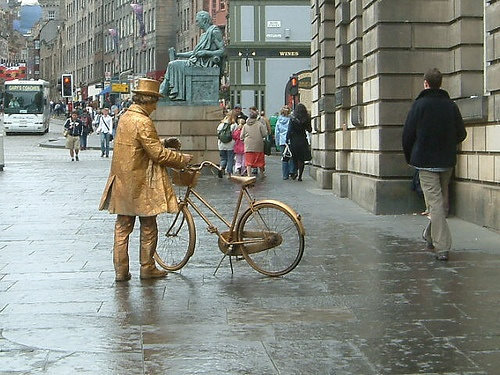

In [ ]:
from IPython.display import Image, display
display(Image('targetdir/JPEGImages/2007_000793.jpg', width = 400, height = 400))

In [ ]:
# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 256, 256)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 256, 256)
        plt.figure(figsize = (18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [ ]:
#Data Generation

path = "targetdir/JPEGImages/"
batch_size = 32 

class RealPhotosDataset(Dataset):
    def __init__(self, directory):
        self.files = [os.path.join(directory, f) for f in os.listdir(directory)]

    def __getitem__(self, index):
        img = PIL.Image.open(self.files[index]).convert('RGB')
        img = img.resize((256, 256))
        img = np.array(img) / 255.0
        img = np.transpose(img,(2,0,1)).astype('float32')
        return torch.tensor(img-0.5)
    
    def __len__(self):
      return len(self.files)

data_set = RealPhotosDataset(path)
img=data_set.__getitem__(0);

train_len = int(len(data_set) * 0.9)
train_set, test_set = random_split(data_set, [train_len, len(data_set) - train_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=5)
test_loader = DataLoader(test_set, batch_size=4, num_workers=5)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ReNetBlock(nn.Module):
    def __init__(self,infil=64,outfil=64):
        super(ReNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(infil, outfil, kernel_size=3, stride=1,padding=1)
        self.bn1 =  nn.InstanceNorm2d(outfil)
        self.relu1 =  nn.ReLU(False)

        self.conv2 = nn.Conv2d(outfil, outfil, kernel_size=3, stride=1,padding=1)
        self.bn2 = nn.InstanceNorm2d(outfil)
        self.relu2 =  nn.ReLU(False)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu2(out)

        return out


class ConvBNR(nn.Module):
  def __init__(self,in_channels,out_channels,activation=nn.LeakyReLU(0.2, False),kw=3,strides=2,pad=1):
        super(ConvBNR, self).__init__()
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size=kw, stride=strides,padding=pad)
        self.bn1 =nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation

  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)))


class TransposeConvBNR(nn.Module):
  def __init__(self, in_channels, out_channels, activation =nn.LeakyReLU(0.2, False), kw=4, strides=2, pad=1):
        super(TransposeConvBNR, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kw, stride=strides, padding=pad)
        self.bn1 = nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation

  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)))


class VAE2_encoder(nn.Module):
    def __init__(self, in_channels=3, n_res_blocks=4, n_layers=5):
        super(VAE2_encoder, self).__init__()
        self.n_layers = n_layers
        self.layer = nn.ModuleList()
        self.layer1 = ConvBNR(in_channels, 64, kw=7, pad=3, strides=1)
        for j in range(n_layers):
            self.layer.append(ConvBNR(64, 64))

        self.res_blks=nn.ModuleList()
        self.n_res_blocks=n_res_blocks
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64,64))

    def forward(self, x):
        x = self.layer1(x)
        for j in range(self.n_layers):
          x = self.layer[j](x)

        for j in range(self.n_res_blocks):
           x = self.res_blks[j](x)
        return x


class VAE2_decoder(nn.Module):
    def __init__(self, in_channels=64, out_channel=3, n_res_blocks=4, n_layers=5):
        super(VAE2_decoder, self).__init__()
        self.n_layers = n_layers
        self.layer = nn.ModuleList()
        for j in range(n_layers):
            self.layer.append(TransposeConvBNR(64,64,pad=1))

        self.layer1 = nn.Conv2d(64, out_channel, kernel_size=1, stride=1)
        self.res_blks = nn.ModuleList()
        self.n_res_blocks = n_res_blocks
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64, 64))

    def forward(self, x):
        for j in range(self.n_res_blocks):
           x = self.res_blks[j](x)
        
        for j in range(self.n_layers):
            x = self.layer[j](x)
        x = self.layer1(x)
        return x


class VAE2(nn.Module):
  def __init__(self,z_dim=256):
        super(VAE2, self).__init__()
        self.n_layers = 2
        self.down_fact = 2**self.n_layers
        down_img_size = 256 // self.down_fact
        self.fdim = (down_img_size)**2 * 64
        self.size = [64, down_img_size, down_img_size]
        self.encoder = VAE2_encoder(n_layers = self.n_layers)
        self.decoder = VAE2_decoder(n_layers = self.n_layers)
        self.fc1 = nn.Linear(self.fdim, z_dim)
        self.fc2 = nn.Linear(self.fdim, z_dim)
        self.fc3 = nn.Linear(z_dim, self.fdim)

  def flat(self, input):
        return input.view(input.size(0), 1, -1)

  def unflat(self, input):
        return input.view(input.size(0), self.size[0], self.size[1], self.size[2])

  def init_weights(self, init_type="xavier", gain=0.02):
      def init_func(m):
          classname = m.__class__.__name__
          if classname.find("BatchNorm2d") != -1:
              if hasattr(m, "weight") and m.weight is not None:
                  init.normal_(m.weight.data, 1.0, gain)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Conv") != -1):
              if init_type == "normal":
                  init.normal_(m.weight.data, 0.0, gain)
              elif init_type == "xavier":
                  init.xavier_normal_(m.weight.data, gain=gain)
              elif init_type == "xavier_uniform":
                  init.xavier_uniform_(m.weight.data, gain=1.0)
              elif init_type == "kaiming":
                  init.kaiming_normal_(m.weight.data, a=0, mode="fan_in")
              elif init_type == "orthogonal":
                  init.orthogonal_(m.weight.data, gain=gain)
              elif init_type == "none":  # uses pytorch's default init method
                  m.reset_parameters()
              else:
                  raise NotImplementedError("initialization method [%s] is not implemented" % init_type)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Linear") != -1):
              init.normal_(m.weight.data,0.0,gain)

      self.apply(init_func)
      for m in self.children():
            if hasattr(m, "init_weights"):
                m.init_weights(init_type, gain)
        
  def reparameterize(self, mu, logvar):
      std = logvar.mul(0.5).exp_()
      esp = torch.randn(*mu.size()).to(device)
      z = mu + std * esp  
      return z
  
  def bottleneck(self, h):
      mu, logvar = self.fc1(h), self.fc2(h)
      logvar = logvar * 1e-3 #Lazy way to stabilize the training.
      z = self.reparameterize(mu, logvar)
      return z, mu, logvar

  def encode(self, x):
      h = self.encoder(x)
      h = self.flat(h)
      z, mu, logvar = self.bottleneck(h)
      return z, mu, logvar

  def decode(self, z):
      z = self.fc3(z)
      z_img = self.unflat(z)
      z = self.decoder(z_img)
      return z,z_img

  def forward(self, x):
      z, mu, logvar = self.encode(x)
      z, z_out = self.decode(z)
      return z, mu, logvar, z_out

bottle neck image resolution 64
bottle neck dim is 262144..!


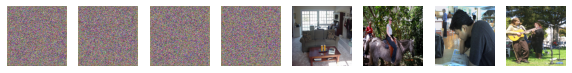

====> Test set loss: 0.2541
Epoch 1: 100%|██████████| 482/482 [01:27<00:00,  5.52batch/s, kl_loss=0.133, l1_loss=0.00745, loss=0.14]
====> Epoch: 1 Average loss: 0.1404
====> Test set loss: 0.0856
Epoch 2: 100%|██████████| 482/482 [01:26<00:00,  5.57batch/s, kl_loss=0.0042, l1_loss=0.00718, loss=0.0114]
====> Epoch: 2 Average loss: 0.0114
====> Test set loss: 0.1387
Epoch 3: 100%|██████████| 482/482 [01:27<00:00,  5.50batch/s, kl_loss=0.00294, l1_loss=0.00716, loss=0.0101]
====> Epoch: 3 Average loss: 0.0101
====> Test set loss: 0.0693
Epoch 4: 100%|██████████| 482/482 [01:27<00:00,  5.54batch/s, kl_loss=0.00233, l1_loss=0.00715, loss=0.00948]
====> Epoch: 4 Average loss: 0.0095
====> Test set loss: 0.0732
Epoch 5: 100%|██████████| 482/482 [01:27<00:00,  5.53batch/s, kl_loss=1.41, l1_loss=0.00716, loss=1.41]
====> Epoch: 5 Average loss: 1.4145


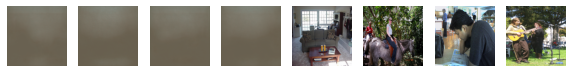

====> Test set loss: 0.3809
Epoch 6: 100%|██████████| 482/482 [01:27<00:00,  5.51batch/s, kl_loss=0.0139, l1_loss=0.00714, loss=0.021]
====> Epoch: 6 Average loss: 0.0210
====> Test set loss: 0.1007
Epoch 7: 100%|██████████| 482/482 [01:27<00:00,  5.51batch/s, kl_loss=0.00493, l1_loss=0.00703, loss=0.012]
====> Epoch: 7 Average loss: 0.0120
====> Test set loss: 0.0904
Epoch 8: 100%|██████████| 482/482 [01:27<00:00,  5.51batch/s, kl_loss=0.00429, l1_loss=0.00705, loss=0.0113]
====> Epoch: 8 Average loss: 0.0113
====> Test set loss: 0.1248
Epoch 9: 100%|██████████| 482/482 [01:27<00:00,  5.50batch/s, kl_loss=0.0123, l1_loss=0.00708, loss=0.0194]
====> Epoch: 9 Average loss: 0.0194
====> Test set loss: 0.2086
Epoch 10: 100%|██████████| 482/482 [01:27<00:00,  5.51batch/s, kl_loss=0.0181, l1_loss=0.0071, loss=0.0251]
====> Epoch: 10 Average loss: 0.0251


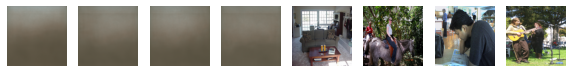

====> Test set loss: 0.0882
Epoch 11: 100%|██████████| 482/482 [01:27<00:00,  5.52batch/s, kl_loss=0.0196, l1_loss=0.00711, loss=0.0268]
====> Epoch: 11 Average loss: 0.0268
====> Test set loss: 0.1938
Epoch 12: 100%|██████████| 482/482 [01:27<00:00,  5.53batch/s, kl_loss=0.0212, l1_loss=0.00712, loss=0.0283]
====> Epoch: 12 Average loss: 0.0283
====> Test set loss: 0.1912
Epoch 13: 100%|██████████| 482/482 [01:27<00:00,  5.52batch/s, kl_loss=0.0402, l1_loss=0.00713, loss=0.0473]
====> Epoch: 13 Average loss: 0.0473
====> Test set loss: 0.1628
Epoch 14: 100%|██████████| 482/482 [01:27<00:00,  5.51batch/s, kl_loss=0.00852, l1_loss=0.00712, loss=0.0156]
====> Epoch: 14 Average loss: 0.0156
====> Test set loss: 0.0806
Epoch 15: 100%|██████████| 482/482 [01:27<00:00,  5.52batch/s, kl_loss=0.237, l1_loss=0.00712, loss=0.244]
====> Epoch: 15 Average loss: 0.2437


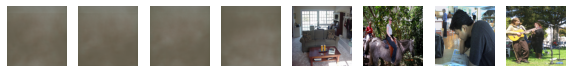

====> Test set loss: 0.0934
Epoch 16: 100%|██████████| 482/482 [01:27<00:00,  5.53batch/s, kl_loss=0.005, l1_loss=0.00711, loss=0.0121]
====> Epoch: 16 Average loss: 0.0121
====> Test set loss: 0.1592
Epoch 17: 100%|██████████| 482/482 [01:27<00:00,  5.54batch/s, kl_loss=0.00935, l1_loss=0.00714, loss=0.0165]
====> Epoch: 17 Average loss: 0.0165
====> Test set loss: 0.0700
Epoch 18: 100%|██████████| 482/482 [01:27<00:00,  5.54batch/s, kl_loss=0.0118, l1_loss=0.00714, loss=0.0189]
====> Epoch: 18 Average loss: 0.0189
====> Test set loss: 0.0921
Epoch 19: 100%|██████████| 482/482 [01:26<00:00,  5.55batch/s, kl_loss=0.0164, l1_loss=0.00714, loss=0.0236]
====> Epoch: 19 Average loss: 0.0236
====> Test set loss: 0.1352
Epoch 20: 100%|██████████| 482/482 [01:27<00:00,  5.53batch/s, kl_loss=0.0153, l1_loss=0.00714, loss=0.0224]
====> Epoch: 20 Average loss: 0.0224


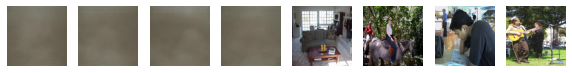

====> Test set loss: 0.1286
Epoch 21: 100%|██████████| 482/482 [01:23<00:00,  5.74batch/s, kl_loss=0.0169, l1_loss=0.00715, loss=0.0241]
====> Epoch: 21 Average loss: 0.0241
====> Test set loss: 0.0847
Epoch 22: 100%|██████████| 482/482 [01:23<00:00,  5.74batch/s, kl_loss=0.497, l1_loss=0.00711, loss=0.504]
====> Epoch: 22 Average loss: 0.5036
====> Test set loss: 0.1333
Epoch 23: 100%|██████████| 482/482 [01:24<00:00,  5.73batch/s, kl_loss=0.00507, l1_loss=0.00702, loss=0.0121]
====> Epoch: 23 Average loss: 0.0121
====> Test set loss: 0.0855
Epoch 24: 100%|██████████| 482/482 [01:24<00:00,  5.73batch/s, kl_loss=0.00338, l1_loss=0.00706, loss=0.0104]
====> Epoch: 24 Average loss: 0.0104
====> Test set loss: 0.0777
Epoch 25: 100%|██████████| 482/482 [01:23<00:00,  5.74batch/s, kl_loss=0.0107, l1_loss=0.00711, loss=0.0178]
====> Epoch: 25 Average loss: 0.0178


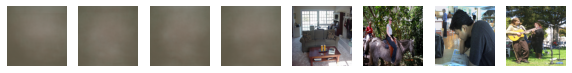

====> Test set loss: 0.1419
Epoch 26: 100%|██████████| 482/482 [01:24<00:00,  5.72batch/s, kl_loss=0.0133, l1_loss=0.00712, loss=0.0204]
====> Epoch: 26 Average loss: 0.0204
====> Test set loss: 0.1298
Epoch 27: 100%|██████████| 482/482 [01:24<00:00,  5.73batch/s, kl_loss=0.0193, l1_loss=0.00713, loss=0.0264]
====> Epoch: 27 Average loss: 0.0264
====> Test set loss: 0.0875
Epoch 28: 100%|██████████| 482/482 [01:24<00:00,  5.72batch/s, kl_loss=0.0166, l1_loss=0.00713, loss=0.0237]
====> Epoch: 28 Average loss: 0.0237
====> Test set loss: 0.1139
Epoch 29: 100%|██████████| 482/482 [01:24<00:00,  5.72batch/s, kl_loss=0.0196, l1_loss=0.00714, loss=0.0267]
====> Epoch: 29 Average loss: 0.0267
====> Test set loss: 0.0710
Epoch 30: 100%|██████████| 482/482 [01:24<00:00,  5.73batch/s, kl_loss=0.0167, l1_loss=0.00713, loss=0.0239]
====> Epoch: 30 Average loss: 0.0239


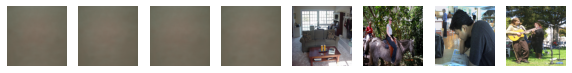

====> Test set loss: 0.2809
Epoch 31: 100%|██████████| 482/482 [01:24<00:00,  5.71batch/s, kl_loss=0.237, l1_loss=0.00711, loss=0.244]
====> Epoch: 31 Average loss: 0.2438
====> Test set loss: 0.0799
Epoch 32: 100%|██████████| 482/482 [01:24<00:00,  5.71batch/s, kl_loss=0.00261, l1_loss=0.00703, loss=0.00964]
====> Epoch: 32 Average loss: 0.0096
====> Test set loss: 0.0719
Epoch 33: 100%|██████████| 482/482 [01:24<00:00,  5.71batch/s, kl_loss=0.00397, l1_loss=0.00707, loss=0.011]
====> Epoch: 33 Average loss: 0.0110
====> Test set loss: 0.3408
Epoch 34: 100%|██████████| 482/482 [01:24<00:00,  5.71batch/s, kl_loss=0.00676, l1_loss=0.00708, loss=0.0138]
====> Epoch: 34 Average loss: 0.0138
====> Test set loss: 0.1220
Epoch 35: 100%|██████████| 482/482 [01:24<00:00,  5.72batch/s, kl_loss=0.0101, l1_loss=0.00708, loss=0.0172]
====> Epoch: 35 Average loss: 0.0172


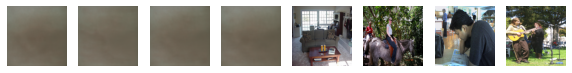

====> Test set loss: 0.1764
Epoch 36: 100%|██████████| 482/482 [01:25<00:00,  5.63batch/s, kl_loss=0.0127, l1_loss=0.00708, loss=0.0198]
====> Epoch: 36 Average loss: 0.0198
====> Test set loss: 0.0663
Epoch 37: 100%|██████████| 482/482 [01:25<00:00,  5.66batch/s, kl_loss=0.0133, l1_loss=0.00707, loss=0.0203]
====> Epoch: 37 Average loss: 0.0203
====> Test set loss: 0.5243
Epoch 38: 100%|██████████| 482/482 [01:25<00:00,  5.62batch/s, kl_loss=0.0164, l1_loss=0.00706, loss=0.0234]
====> Epoch: 38 Average loss: 0.0234
====> Test set loss: 0.1734
Epoch 39: 100%|██████████| 482/482 [01:25<00:00,  5.65batch/s, kl_loss=0.293, l1_loss=0.00704, loss=0.3]
====> Epoch: 39 Average loss: 0.3003
====> Test set loss: 0.0846
Epoch 40: 100%|██████████| 482/482 [01:25<00:00,  5.66batch/s, kl_loss=0.00284, l1_loss=0.00701, loss=0.00985]
====> Epoch: 40 Average loss: 0.0098


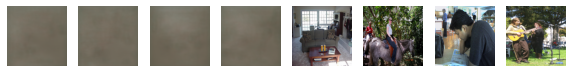

====> Test set loss: 0.0704
Epoch 41: 100%|██████████| 482/482 [01:27<00:00,  5.52batch/s, kl_loss=0.00206, l1_loss=0.007, loss=0.00907]
====> Epoch: 41 Average loss: 0.0091
====> Test set loss: 0.0743
Epoch 42: 100%|██████████| 482/482 [01:26<00:00,  5.55batch/s, kl_loss=0.00606, l1_loss=0.007, loss=0.0131]
====> Epoch: 42 Average loss: 0.0131
====> Test set loss: 0.1131
Epoch 43: 100%|██████████| 482/482 [01:26<00:00,  5.54batch/s, kl_loss=0.00822, l1_loss=0.007, loss=0.0152]
====> Epoch: 43 Average loss: 0.0152
====> Test set loss: 0.0733
Epoch 44: 100%|██████████| 482/482 [01:26<00:00,  5.54batch/s, kl_loss=0.00939, l1_loss=0.007, loss=0.0164]
====> Epoch: 44 Average loss: 0.0164
====> Test set loss: 1.2147
Epoch 45: 100%|██████████| 482/482 [01:27<00:00,  5.51batch/s, kl_loss=0.0112, l1_loss=0.00698, loss=0.0182]
====> Epoch: 45 Average loss: 0.0182


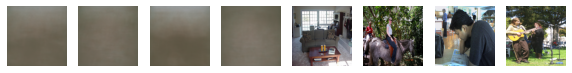

====> Test set loss: 0.0869
Epoch 46: 100%|██████████| 482/482 [01:24<00:00,  5.73batch/s, kl_loss=0.0138, l1_loss=0.00698, loss=0.0208]
====> Epoch: 46 Average loss: 0.0208
====> Test set loss: 4.6622
Epoch 47:  26%|██▌       | 124/482 [00:22<01:01,  5.80batch/s, kl_loss=0.00272, l1_loss=0.00181, loss=0.00453]Buffered data was truncated after reaching the output size limit.

In [ ]:
learning_rate = 2e-4
epochs = 200
steps = 1

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate, betas=(0.5, 0.999)
)

model=VAE2().to(device)
l1_loss=torch.nn.L1Loss()
means, logvars = [], []

writer = SummaryWriter('./logs/')

for epoch in range(0, epochs + 1):

    # Training
    if epoch > 0:  # test untrained net first
        model.train()

        train_loss = 0
        kl_loss = 0
        norm1_loss = 0

        with tqdm.tqdm(train_loader, total=int(len(train_loader)), unit="batch", position=0, leave=True) as tepoch:
          for x in tepoch:
              tepoch.set_description(f"Epoch {epoch}")
              x = x.to(device)
              x_hat, mu, logvar,z1 = model(x)

              loss1 = l1_loss(x_hat, x)
              loss2 = torch.mean(0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1. - logvar, 1))
              loss = loss1 + loss2
              kl_loss += loss2.item()
              norm1_loss += loss1.item()
              train_loss += loss.item()

              writer.add_scalar("loss/l1_loss", loss1.item(), steps)
              writer.add_scalar("loss/kl_loss", loss2.item(), steps)
              steps += 1

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              tepoch.set_postfix(loss=train_loss / len(train_loader.dataset),
                                 l1_loss=norm1_loss/ len(train_loader.dataset), 
                                 kl_loss=kl_loss/ len(train_loader.dataset))
              
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    with torch.no_grad():
        model.eval()
        test_loss = 0.0

        for ix, x in enumerate(test_loader):
            x = x.to(device)
            x_hat, mu, logvar, _ = model(x)
            loss = 0.0
            loss += l1_loss(x_hat, x)
            loss+= torch.mean(0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1. - logvar, 1))
            test_loss+=loss.item()

            if (ix<1 and epoch % 5) == 0:
              plt.figure(figsize=(10, 4))
              for i in range(4):
                  plt.subplot(1,8, i+1)
                  plt.imshow(np.clip(x_hat.detach().cpu().numpy()[i, :, :, :].transpose(1, 2, 0)+0.5, 0.0, 1.0))
                  plt.axis('off')

              for i in range(4):
                  plt.subplot(1, 8, i + 1 + 4)
                  plt.imshow(np.clip(x.detach().cpu().numpy()[i, :, :].transpose(1, 2, 0)+0.5, 0.0, 1.0))
                  plt.axis('off')
              plt.show()

    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    #display_images(x, x_hat, 1, f'Epoch {epoch}')